# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

## **Edición 2024**


----

# Trabajo práctico entregable - parte 2


Trabajaremos con la base de datos de `melb_data` presentada a continuación.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas

import seaborn
seaborn.set_context('talk')

In [2]:
# Acá deberían leer el conjunto de datos que ya tienen.
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas.
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


### Respuestas Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

Información del conjunto de datos del dataframe "melb_df"

In [3]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

Sobre el dataframe, aplicamos el analisis de los valores extremos realizado en el Entregable_1, para las columnas "Rooms", "Car" y "Distance", este nuevo dataframe se llamará "melb_df2"

In [4]:
melb_df2 = melb_df[ (melb_df['Rooms'] < 6) & (melb_df['Distance'] < 25 ) & (melb_df['Car'] < 5)]

Tambien eliminamos las siguientes columnas 'Address','Method', 'Bedroom2' y 'Date'

In [5]:
melb_df2 = melb_df.drop(columns=['Address','Method', 'Date', 'Bedroom2'])

Seleccionamos todas las filas y columnas del conjunto de datos excepto **BuildinArea** y **YearBuilt**

In [6]:
melb_df2 = melb_df2.drop(columns=['YearBuilt', 'BuildingArea'])
melb_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Rooms          13580 non-null  int64  
 2   Type           13580 non-null  object 
 3   Price          13580 non-null  float64
 4   SellerG        13580 non-null  object 
 5   Distance       13580 non-null  float64
 6   Postcode       13580 non-null  float64
 7   Bathroom       13580 non-null  float64
 8   Car            13518 non-null  float64
 9   Landsize       13580 non-null  float64
 10  CouncilArea    12211 non-null  object 
 11  Lattitude      13580 non-null  float64
 12  Longtitude     13580 non-null  float64
 13  Regionname     13580 non-null  object 
 14  Propertycount  13580 non-null  float64
dtypes: float64(9), int64(1), object(5)
memory usage: 1.6+ MB


2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Para resolver este punto, vamos a utilizar las variables categoricas de interes encontradas en el **Entregable 1**, donde cambiamos "Address" por "Regionname" ya que brindaria mas información

In [7]:
interesting_columns_categ_to_encode = ['Suburb', 'Type', 'CouncilArea', 'Regionname','SellerG']

In [8]:
#Creamos todas las categóricas
counter = 0

for category in interesting_columns_categ_to_encode:
  counter += melb_df2[category].nunique()

print(f'El nuevo dataframe con one-hot enconding tendrá {counter} columnas categóricas adicionales')

El nuevo dataframe con one-hot enconding tendrá 626 columnas categóricas adicionales


Revisaremos también si de estas variables hay celdas nulas. De todas maneras, esto no debería representar un problema. Serán filas que tendrán cero en todas las opciones disponibles para esa categoría

In [9]:
melb_df2[interesting_columns_categ_to_encode].isna().sum()

Suburb            0
Type              0
CouncilArea    1369
Regionname        0
SellerG           0
dtype: int64

Para crear las variables binarias lo haremos con el método get_dummies.

In [10]:
suburb_df = pd.get_dummies(melb_df2['Suburb'],prefix='Suburb', drop_first = False)
type_df = pd.get_dummies(melb_df2['Type'],prefix='Type', drop_first = False)
council_area_df = pd.get_dummies(melb_df2['CouncilArea'],prefix='CouncilArea', drop_first = False)
regionname_df = pd.get_dummies(melb_df2['Regionname'],prefix='RegionName', drop_first = False)
sellerG_df = pd.get_dummies(melb_df2['SellerG'],prefix='SellerG', drop_first = False)

La resolución de este ejercicio pide también la codificación en one-hot de las variables numéricas. Veamos cuales son las variables numéricas con posibilidad de selección y realizaremos el mismo conteo de ampliación de la dimensión que para las categóricas

In [11]:
numerical_cols = ['Rooms', 'Price', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'Landsize', 'Lattitude',
       'Longtitude', 'Propertycount']

counter = 0

for category in numerical_cols:
  counter += melb_df2[category].nunique()

print(f'El nuevo dataframe con one-hot enconding tendrá {counter} columnas numéricas adicionales')

El nuevo dataframe con one-hot enconding tendrá 17958 columnas numéricas adicionales


Vemos que codificar en one-hot tendría un crecimiento inmenso. Asimismo, para la mayoría de las variables numéricas no tiene sentido pues -algunas además de ser contínuas- representan lo esperado sin una transformación one-hot. Pensemos en la columna Price por ejemplo

In [12]:
melb_df2['Price'].nunique()

2204

Aplicando one-hot a esta columna no solo estamos añadiendo más de 2mil nuevas columnas, si no que no reviste demasiado sentido. Es correcto que el precio se muestre de la manera en la que está. Luego se podría ponderar según más barato o más caro y la elección de las personas para comprarla.

Por esta razón tomaremos tres columnas con pocos valores únicos que puede ser importante representarlas en one-hot y que no añaden gran dimensionalidad

In [13]:
print(melb_df2['Rooms'].nunique())
print(melb_df2['Bathroom'].nunique())
print(melb_df2['Car'].nunique())

9
9
11


Volvemos a usar get_dummies para el encoding

In [14]:
rooms_df = pd.get_dummies(melb_df2['Rooms'],prefix='Rooms', drop_first = False)
bathroom_df = pd.get_dummies(melb_df2['Bathroom'],prefix='Bathroom', drop_first = False)
car_df = pd.get_dummies(melb_df2['Car'], prefix='Car', drop_first=False)

Ahora vamos a añadir las nuevas columnas -que están en otros dataframes- al dataframe original. Luego, eliminaremos la columna original, que dio lugar al encoding.
Primero las columnas categóricas

In [15]:
# Añadimos las variables binarias al DataFrame
melb_df2 = pd.concat([melb_df2, suburb_df, type_df, council_area_df, regionname_df, sellerG_df], axis = 1)

# Eliminamos las columnas originales, que fueron reemplazadas por los encodings
melb_df2 = melb_df2.drop(columns=['Suburb', 'Type', 'CouncilArea', 'Regionname', 'SellerG'])

Hacemos lo propio con las columnas numéricas

In [16]:
# Añadimos las variables binarias al DataFrame
melb_df2 = pd.concat([melb_df2, rooms_df, bathroom_df, car_df], axis = 1)

# Eliminamos las columnas originales, que fueron reemplazadas por los encodings
melb_df2 = melb_df2.drop(columns=['Rooms', 'Bathroom', 'Car'])

Veamos como quedó el dataframe modificado

In [17]:
melb_df2.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_1.0,Car_2.0,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,True,False,False,...,True,False,False,False,False,False,False,False,False,False
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,True,False,False,...,False,True,False,False,False,False,False,False,False,False


In [18]:
melb_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Columns: 662 entries, Price to Car_10.0
dtypes: bool(655), float64(7)
memory usage: 9.2 MB


## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

## Respuesta Ejercicio 2: Imputación por KNN

**Respuesta:** 1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.

In [19]:
melb_df2 = melb_df2.join(melb_df[['YearBuilt', 'BuildingArea']])

In [20]:
melb_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Columns: 664 entries, Price to BuildingArea
dtypes: bool(655), float64(9)
memory usage: 9.4 MB


**Respuesta:** 2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?

In [21]:
numerical = [var for var in melb_df2.columns if (melb_df2[var].dtype == float) or (melb_df2[var].dtype == int)]
numerical

['Price',
 'Distance',
 'Postcode',
 'Landsize',
 'Lattitude',
 'Longtitude',
 'Propertycount',
 'YearBuilt',
 'BuildingArea']

Sobre las columnas que fueron numericas, vamos a analizar cuales tienen valores nulos

In [22]:
melb_df2[numerical].isnull().sum()

Price               0
Distance            0
Postcode            0
Landsize            0
Lattitude           0
Longtitude          0
Propertycount       0
YearBuilt        5375
BuildingArea     6450
dtype: int64

Analizamos los valores preesntes en la columna "YearBuilt", para tener una idea de los "outliers"



<Axes: xlabel='YearBuilt'>

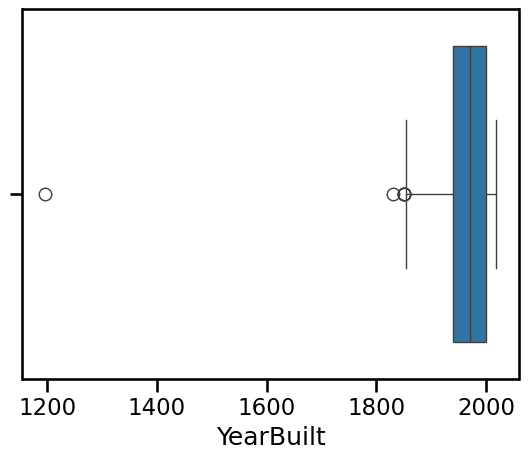

In [23]:
seaborn.boxplot(melb_df2['YearBuilt'] , orient = 'h') #outliers valores <= 1850

Analizamos los valores preesntes en la columna "BuildingArea", para tener una idea de los "outliers"

<Axes: xlabel='BuildingArea'>

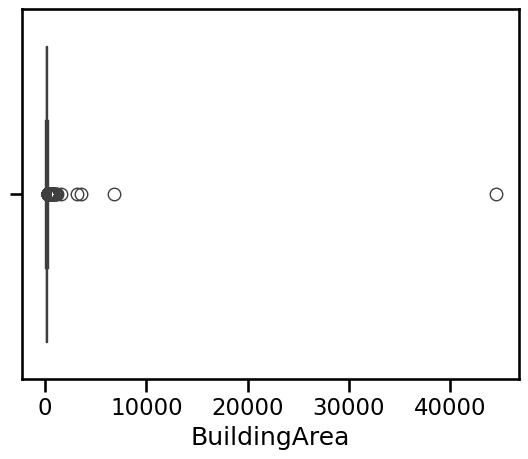

In [24]:
seaborn.boxplot(melb_df2['BuildingArea'] , orient = 'h')

(-10.0, 500.0)

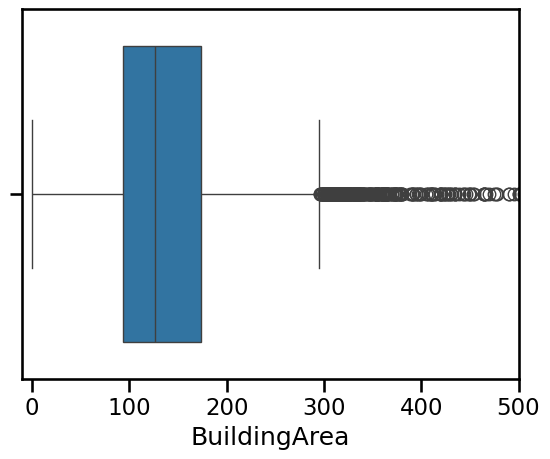

In [25]:
seaborn.boxplot(melb_df2['BuildingArea'] , orient = 'h') #outliers valores > 300
plt.xlim(-10,500)

En base al analisis realizado, podemos concluir que:


*   Para "YearBuilt" los outliers son valores <= 1850
*   Para "BuildingArea" los outliers son valores > 300



Vamos a sacar estos valores "outliers" del dataframe

In [26]:
melb_reduced_pre_mice_df = melb_df2.loc [ (melb_df2['YearBuilt'] > 1850) & (melb_df2['BuildingArea'] < 300 ) | pd.isna(melb_df2['YearBuilt']) & pd.isna(melb_df2['BuildingArea'])]
melb_reduced_pre_mice_df.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0,YearBuilt,BuildingArea
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,1900.0,79.0
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,1900.0,150.0
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,2014.0,142.0


Sobre el dataframe, vamos a imputar sin realizar escalado ni normalizacion y aplicando KNN sobre las columnas "BuildingArea" y "YearBuilt", obtenemos el siguiente grafico.

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

melb_data_mice = melb_reduced_pre_mice_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_data_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_data_mice[['YearBuilt', 'BuildingArea']])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


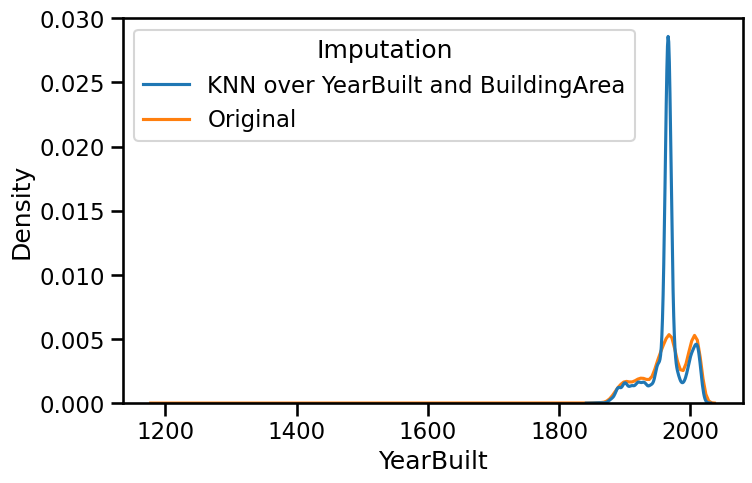

In [28]:
mice_year_built = melb_data_mice.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_year_build = melb_df.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pandas.concat([mice_year_built, melb_year_build])
fig = plt.figure(figsize=(8, 5))
g = seaborn.kdeplot(data=data, x='YearBuilt', hue='Imputation')

(-200.0, 600.0)

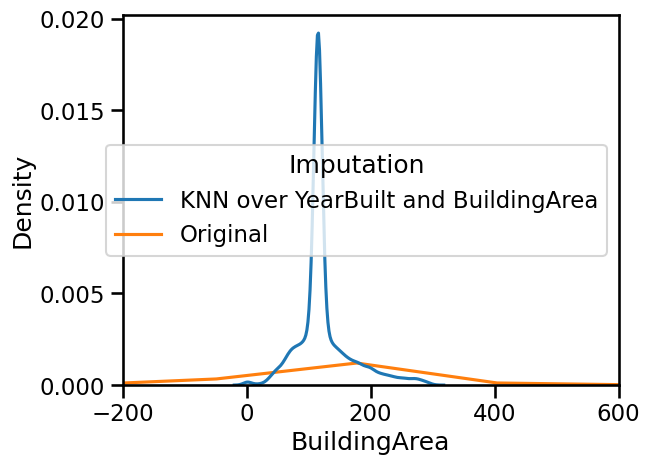

In [29]:
mice_build_area = melb_data_mice.BuildingArea.to_frame()
mice_build_area['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_build_area = melb_df.BuildingArea.dropna().to_frame()
melb_build_area['Imputation'] = 'Original'
data2 = pd.concat([mice_build_area, melb_build_area])

g2 = seaborn.kdeplot(data=data2, x='BuildingArea', hue='Imputation')
plt.xlim(-200,600)

**Como se puede observar al analizar las variables, los valores de BuildingArea son muy distintos a los de YearBuilt. Por este motivo la imputación sin ningún procesamiento de las variables no es correcta. Por eso, primero deben escalarse o normalizarse los datos. Comenzaremos probando el escalamiento de los mismos:**

**Vamos a escalar**

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Copiamos el DF original
melb_scaled_df = melb_reduced_pre_mice_df.copy(deep=True) #realizamos una copia del df que teníamos antes de aplicar la imputación

# Creamos un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustamos y transformamos los datos
scaled_columns=['YearBuilt','BuildingArea']
melb_scaled_df[scaled_columns] = scaler.fit_transform(melb_scaled_df[scaled_columns])

melb_scaled_df.sample(20)

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0,YearBuilt,BuildingArea
2909,525000.0,13.0,3046.0,665.0,-37.69660,144.93310,8870.0,False,False,False,...,False,False,False,False,False,False,False,False,0.585366,0.285034
9952,405000.0,31.7,3337.0,590.0,-37.67815,144.58355,3600.0,False,False,False,...,False,False,False,False,False,False,False,False,0.707317,0.546595
9167,695000.0,11.2,3046.0,649.0,-37.69777,144.91952,8870.0,False,False,False,...,False,False,False,False,False,False,False,False,0.615854,0.318567
5881,648000.0,6.1,3182.0,1208.0,-37.86100,144.98910,13240.0,False,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
3133,418000.0,4.6,3122.0,1056.0,-37.82610,145.03490,11308.0,False,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
3658,610000.0,5.6,3101.0,745.0,-37.80240,145.03460,10331.0,False,False,False,...,False,False,False,False,False,False,False,False,0.695122,0.241441
427,600000.0,12.2,3147.0,153.0,-37.86960,145.09620,2894.0,False,False,False,...,False,False,False,False,False,False,False,False,0.707317,0.268267
8816,755000.0,38.0,3199.0,786.0,-38.16492,145.12656,7566.0,False,False,False,...,False,False,False,False,False,False,False,False,0.646341,0.583481
7479,890000.0,12.2,3147.0,235.0,-37.86250,145.10830,2894.0,False,False,False,...,False,False,False,False,False,False,False,False,0.926829,0.435934
412,1075000.0,12.2,3147.0,695.0,-37.86940,145.09440,2894.0,False,False,False,...,False,False,False,False,False,False,False,False,0.585366,0.382281


**Ahora imputamos utilizando KNN sobre el dataframe escalado**

In [31]:
melb_scaled_mice = melb_scaled_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_scaled_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_scaled_mice[['YearBuilt', 'BuildingArea']])

melb_scaled_mice.head()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0,YearBuilt,BuildingArea
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.447561,0.774307
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.280488,0.264914
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.280488,0.503001
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.447561,0.774307
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.975610,0.476175


**Graficamos los datos que fueron ESCALADOS e IMPUTADOS via KNN**

Text(0.5, 0.98, 'Datos Escalados')

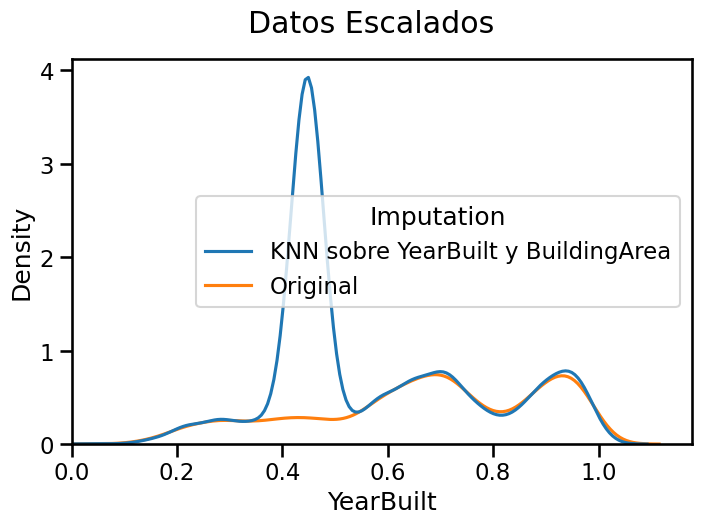

In [32]:
scaled_mice_year_built = melb_scaled_mice.YearBuilt.to_frame()
scaled_mice_year_built['Imputation'] = 'KNN sobre YearBuilt y BuildingArea'
melb_scaled_year_built = melb_scaled_df.YearBuilt.dropna().to_frame()
melb_scaled_year_built['Imputation'] = 'Original'

data3 = pd.concat([scaled_mice_year_built, melb_scaled_year_built])

fig = plt.figure(figsize=(8, 5))
g3 = seaborn.kdeplot(data=data3, x='YearBuilt', hue='Imputation')
plt.xlim(0,None)
plt.suptitle('Datos Escalados')

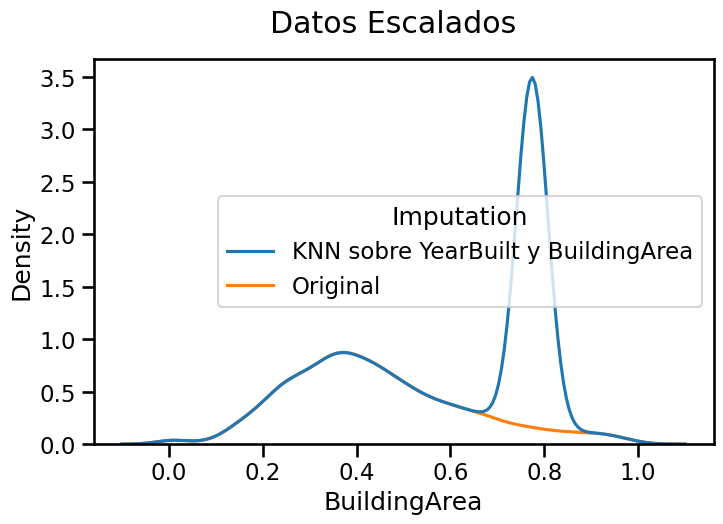

In [33]:
scaled_mice_build_area = melb_scaled_mice.BuildingArea.to_frame()
scaled_mice_build_area['Imputation'] = 'KNN sobre YearBuilt y BuildingArea'
melb_scaled_build_area = melb_scaled_df.BuildingArea.dropna().to_frame()
melb_scaled_build_area['Imputation'] = 'Original'

data4 = pd.concat([scaled_mice_build_area, melb_scaled_build_area])

fig = plt.figure(figsize=(8, 5))
plt.suptitle('Datos Escalados')
g4 = seaborn.kdeplot(data=data4, x='BuildingArea', hue='Imputation')
plt.show()

**Ahora vamos a probar con el Normalizado antes de la imputacion por KNN**

In [34]:
from sklearn.preprocessing import StandardScaler

# Copiamos el DF original
melb_normal_df = melb_reduced_pre_mice_df.copy(deep=True) #realizamos una copia del df que teníamos antes de aplicar la imputación

# Creamos un objeto MinMaxScaler
scaler2 = StandardScaler()

# Ajustamos y transformamos los datos
normalized_columns=['YearBuilt','BuildingArea']
melb_normal_df[normalized_columns] = scaler2.fit_transform(melb_normal_df[normalized_columns])

melb_normal_df.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0,YearBuilt,BuildingArea
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,-1.751380,-0.925482
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,-1.751380,0.334986
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,1.376918,0.192961


**Ahora imputamos utilizando KNN sobre el dataframe normalizado**

In [35]:
melb_normal_mice = melb_normal_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_normal_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_normal_mice[['YearBuilt', 'BuildingArea']])

melb_normal_mice.head()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0,YearBuilt,BuildingArea
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,-0.999491,1.771315
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,-1.751380,-0.925482
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,-1.751380,0.334986
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,-0.999491,1.771315
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,1.376918,0.192961


**Ahora graficamos la imputacion KNN sobre el dataframe Normalizado**

Text(0.5, 0.98, 'Normalized data')

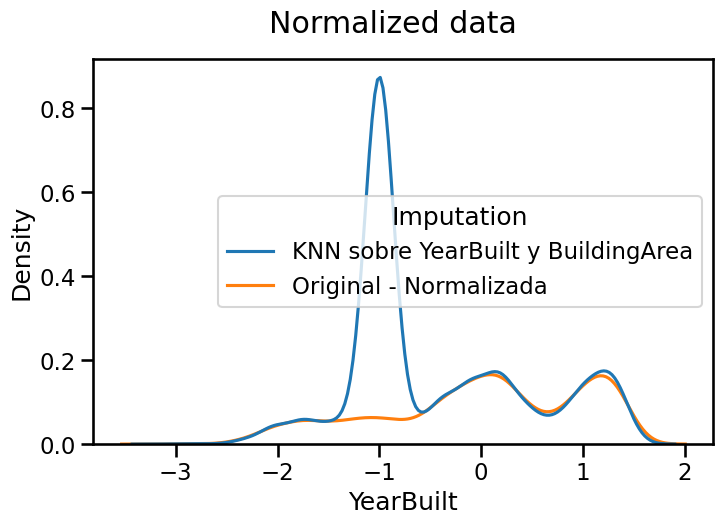

In [36]:
normal_mice_year_built = melb_normal_mice.YearBuilt.to_frame()
normal_mice_year_built['Imputation'] = 'KNN sobre YearBuilt y BuildingArea'
melb_normal_year_built = melb_normal_df.YearBuilt.dropna().to_frame()
melb_normal_year_built['Imputation'] = 'Original - Normalizada'

data5 = pd.concat([normal_mice_year_built, melb_normal_year_built])

fig = plt.figure(figsize=(8, 5))
g5 = seaborn.kdeplot(data=data5, x='YearBuilt', hue='Imputation')
plt.suptitle('Normalized data')

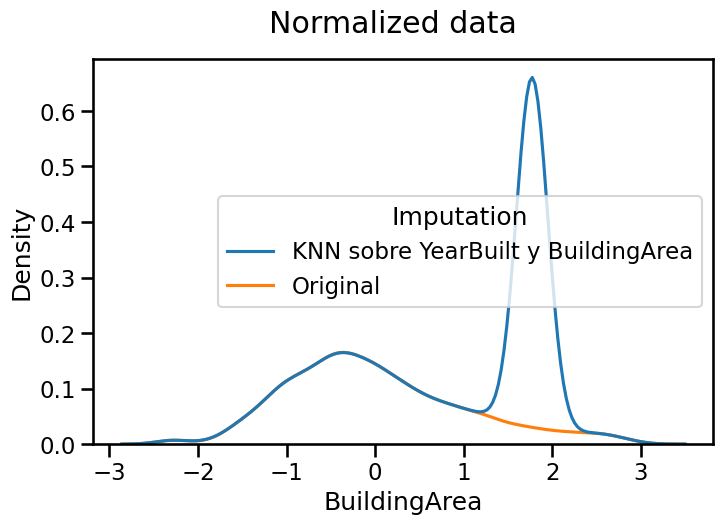

In [37]:
normal_mice_build_area = melb_normal_mice.BuildingArea.to_frame()
normal_mice_build_area['Imputation'] = 'KNN sobre YearBuilt y BuildingArea'
melb_normal_build_area = melb_normal_df.BuildingArea.dropna().to_frame()
melb_normal_build_area['Imputation'] = 'Original'

data6 = pd.concat([normal_mice_build_area, melb_normal_build_area])

fig = plt.figure(figsize=(8, 5))
plt.suptitle('Normalized data')
g6 = seaborn.kdeplot(data=data6, x='BuildingArea', hue='Imputation')
plt.show()

Como se puede observar en los gráficos imputar valores faltantes usando KNN busca acercarse a la distribución de la variable original. Además, realizar una estandarización de los datos antes de imputar por KNN mejora la aproximación de ambas distribuciones. En la variable YearBuilt esto se puede ver con mayor claridad mediante el gráfico.

Los resultados  mejorarían si en la imputación KNN se usaran todas las columnas del dataset. Esto implica, nuevamente, solucionar el problema de dimensionalidad generado por la codificación de las variables categóricas en los incisos anteriores.

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Seleccione las primeras $2$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

## RESPUESTA al Ejercicio 3: Reducción de dimensionalidad.

**1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?**

Aplicar PCA (Análisis de Componentes Principales) a un dataframe se refiere al proceso de reducir su dimensionalidad identificando las direcciones de máxima varianza en los datos. Esto se logra mediante la transformación lineal del dataframe original en un nuevo conjunto de variables ortogonales llamadas componentes principales.

El proceso de PCA identifica aquellas direcciones en las que la varianza es mayor. Como la varianza de una variable se mide en su misma escala elevada al cuadrado, si antes de calcular las componentes no se estandarizan todas las variables para que tengan media 0 y desviación estándar 1, aquellas variables cuya escala sea mayor dominarán al resto. **De ahí que sea recomendable estandarizar siempre los datos.**

**PCA con estandarizado**

In [38]:
melb_pca_df = melb_scaled_mice.copy(deep=True)
melb_pca_df.shape

(11645, 664)

In [39]:
melb_pca_df.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Car_3.0,Car_4.0,Car_5.0,Car_6.0,Car_7.0,Car_8.0,Car_9.0,Car_10.0,YearBuilt,BuildingArea
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.447561,0.774307
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.280488,0.264914
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.280488,0.503001
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.447561,0.774307
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,True,False,False,...,False,False,False,False,False,False,False,False,0.975610,0.476175


Primero trabajamos con estandarización

In [40]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
stdandard_dense_feature_matrix = std_scaler.fit_transform(melb_pca_df)
np.max(stdandard_dense_feature_matrix), np.min(stdandard_dense_feature_matrix)

(107.9073676817297, -5.358194899274959)

In [41]:
from sklearn.decomposition import PCA
pca_st = PCA(n_components=50) #Tomo un valor mayor a 20 que es lo que pide el ejercicio, pero mucho menor que 310, si veo en gráfico que no alcanza a bajar la varianza lo amplio
pca_st.fit(stdandard_dense_feature_matrix)
proyected_features_std = pca_st.transform(stdandard_dense_feature_matrix)
proyected_features_std.shape

(11645, 50)

Luego con la forma escalada

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_dense_feature_matrix = scaler.fit_transform(melb_pca_df)
np.max(scaled_dense_feature_matrix), np.min(scaled_dense_feature_matrix)

(1.0000000000000009, -1.0)

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(scaled_dense_feature_matrix)
proyected_features = pca.transform(scaled_dense_feature_matrix)
proyected_features.shape

(11645, 50)

<function matplotlib.pyplot.legend(*args, **kwargs)>

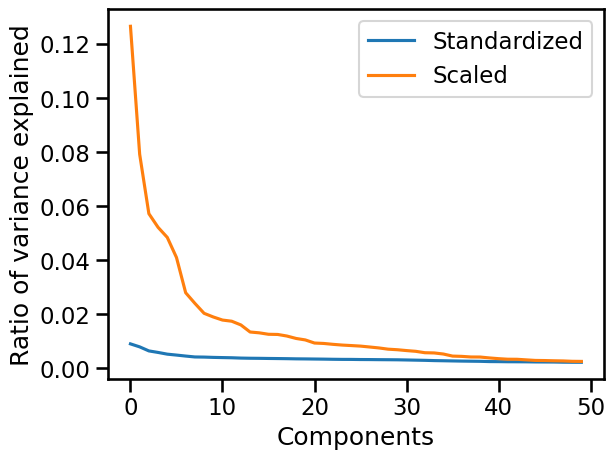

In [45]:
seaborn.lineplot(x=range(pca_st.n_components),
                 y=pca_st.explained_variance_ratio_, label='Standardized')
seaborn.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_, label='Scaled')
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")
plt.legend

El grafico nos dice que es mejor estandarizar ya que con menos de 10 componentes principales capturamos las variables componentes de mayor varianza, mientras que si solo escalamos necesitamos trabajar con al menos 20. Ampliaremos el Grafico para refinar la desición de cuantas PC elegir.

(0.0, 10.0)

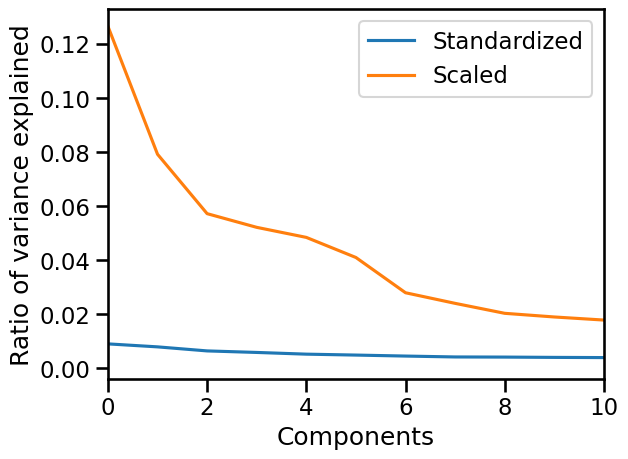

In [46]:
seaborn.lineplot(x=range(pca_st.n_components),
                 y=pca_st.explained_variance_ratio_, label='Standardized')
seaborn.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_, label='Scaled')
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")
plt.legend()
plt.xlim(0,10)

Podriamos decir que con solo 2 PC podemos trabajar.

<Axes: xlabel='pca1_standard', ylabel='pca2_standard'>

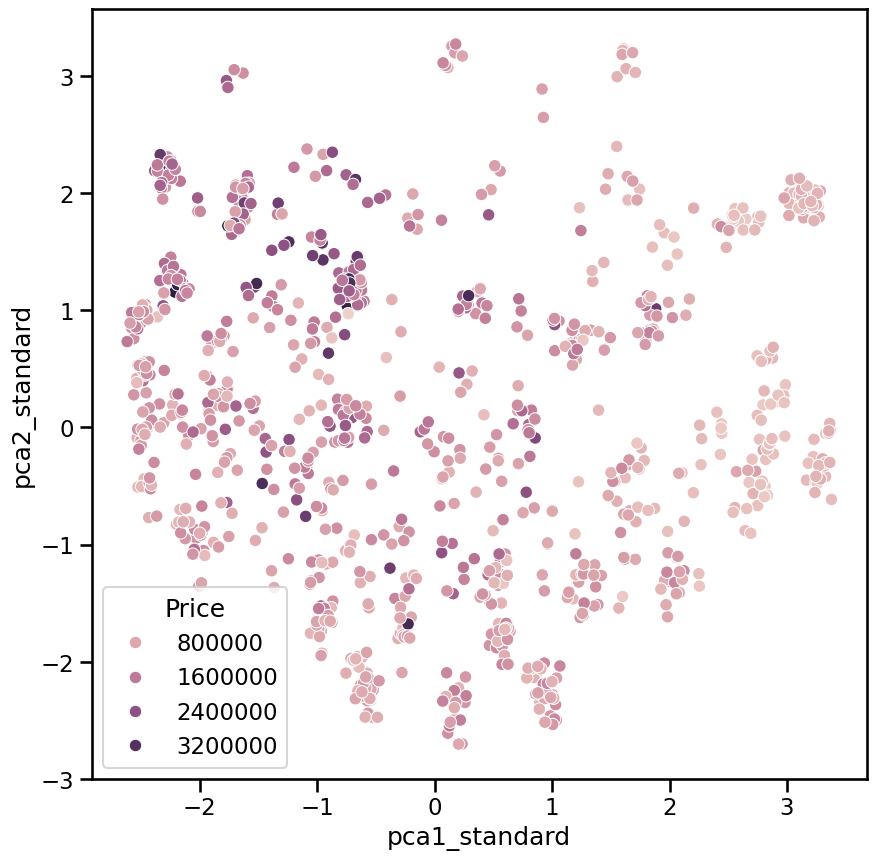

In [47]:
melb_pca_df[['pca1_standard', 'pca2_standard']] = proyected_features[:,:2]
data = melb_pca_df.sample(1000)
fig = plt.figure(figsize=(10, 10))
seaborn.scatterplot(data=data, x='pca1_standard', y='pca2_standard',
                   hue='Price')  # 'Landsize' 'Price' 'YearBuilt'

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [54]:
melb_df_curado= melb_pca_df.copy(deep=True)
melb_df_curado.to_csv("melb_df_curado.csv", index=None)
from google.colab import files
files.download('melb_df_curado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Small example
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## If we process our data with the following steps:
categorical_cols = ['Type', 'Regionname']
numerical_cols = ['Rooms', 'Distance']
new_columns = []

# Step 1: encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(melb_df[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 2: Append the numerical columns
X = numpy.hstack([X_cat, melb_df[numerical_cols].values])
new_columns.extend(numerical_cols)
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 3: Append some new features, like PCA
pca = PCA(n_components=2)
pca_dummy_features = pca.fit_transform(X)
X_pca = numpy.hstack([X, pca_dummy_features])
new_columns.extend(['pca1', 'pca2'])

## Re-build dataframe
processed_melb_df = pandas.DataFrame(data=X_pca, columns=new_columns)
processed_melb_df.head()

Matrix has shape (13580, 11), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria']
Matrix has shape (13580, 11), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria', 'Rooms', 'Distance']


,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria,Rooms,Distance,pca1,pca2
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.669418,-0.292703
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.669418,-0.292703
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.620201,0.619633
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.620201,0.619633
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.5,-7.570984,1.531969


## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de
     publicaciones de la plataforma AirBnB en el mismo código
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
